# <div id="chap1">1. Import libraries

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
# import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [2]:
import yfinance as yf

# <div id="chap2">2. Preprocessing

In [3]:
stock_name = "^GSPC"
date_predict_start = '2019-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
# n_harm_lower_limit = 1
# n_harm_upper_limit = 50
# fit_method = 'rmse'
# pv_method = 'CL'

In [4]:
COMPANY = '^GSPC'

In [5]:
data = yf.download(COMPANY, start='1999-01-01', end='2019-06-30')
len(data)

[*********************100%***********************]  1 of 1 completed


5155

In [6]:
array_data = np.array(data['Close'])
n_data = array_data.size
time_data = np.arange(0, n_data)
Polynomial = np.polyfit(time_data, array_data, 1)
data_notrend = array_data - Polynomial[0] * time_data  # detrended x
data['Close'] = data_notrend

In [7]:
train_data = data.loc[data.index < date_predict_start]
print(len(train_data))
test_data = data.loc[data.index > date_predict_start]
print(len(test_data))

5031
124


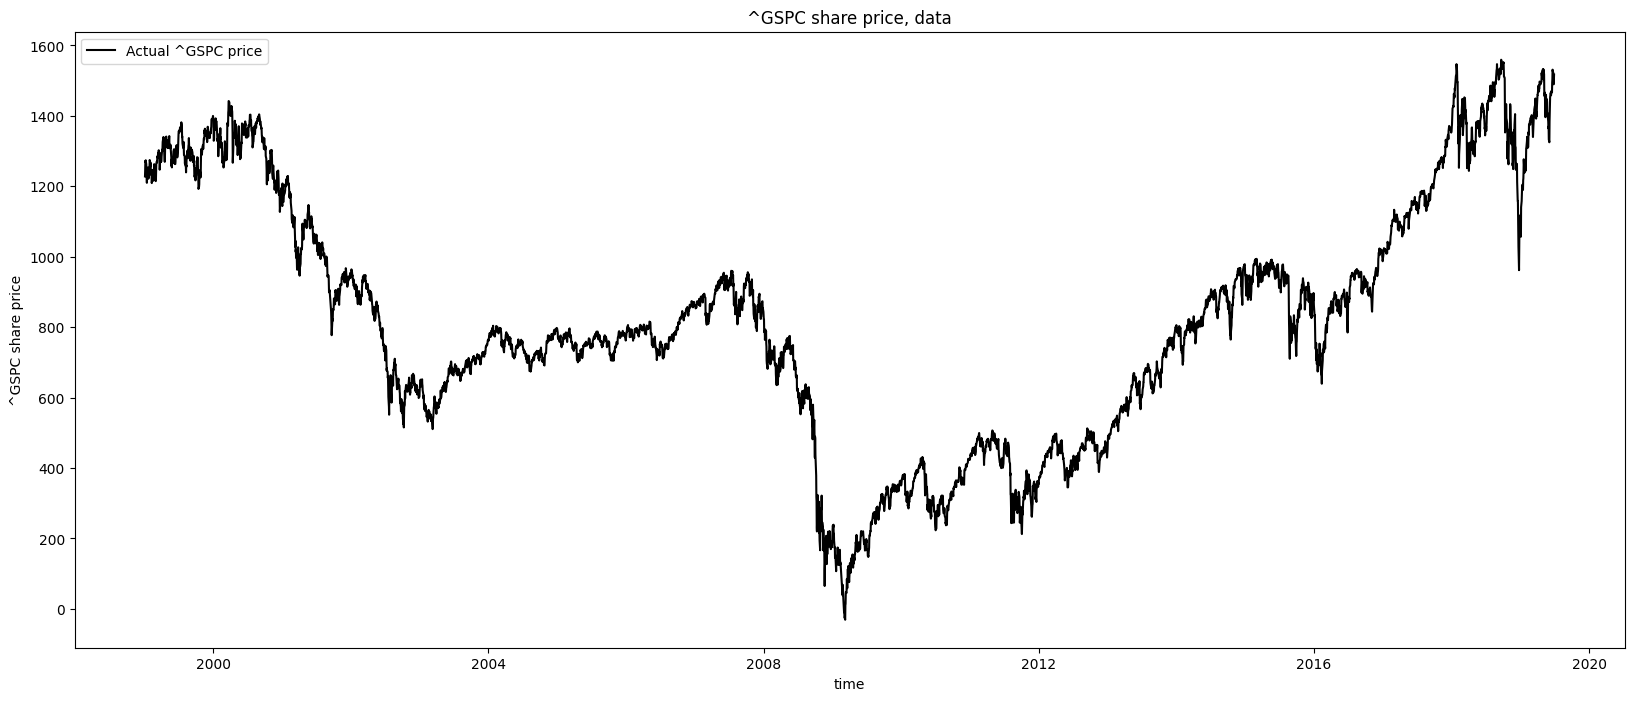

In [8]:
plt.figure(figsize=(20, 8))
plt.plot(data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, data")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

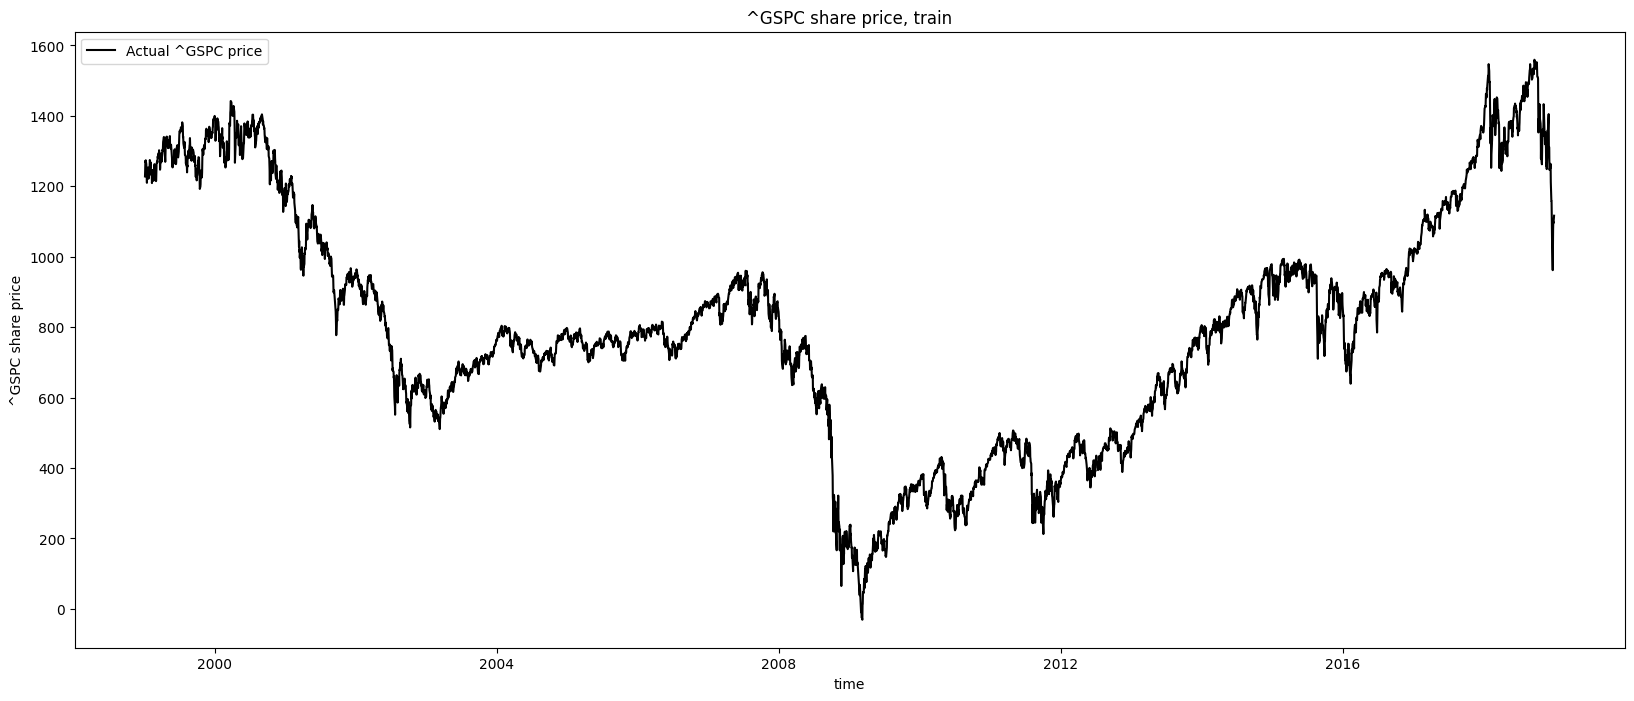

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(train_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, train")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

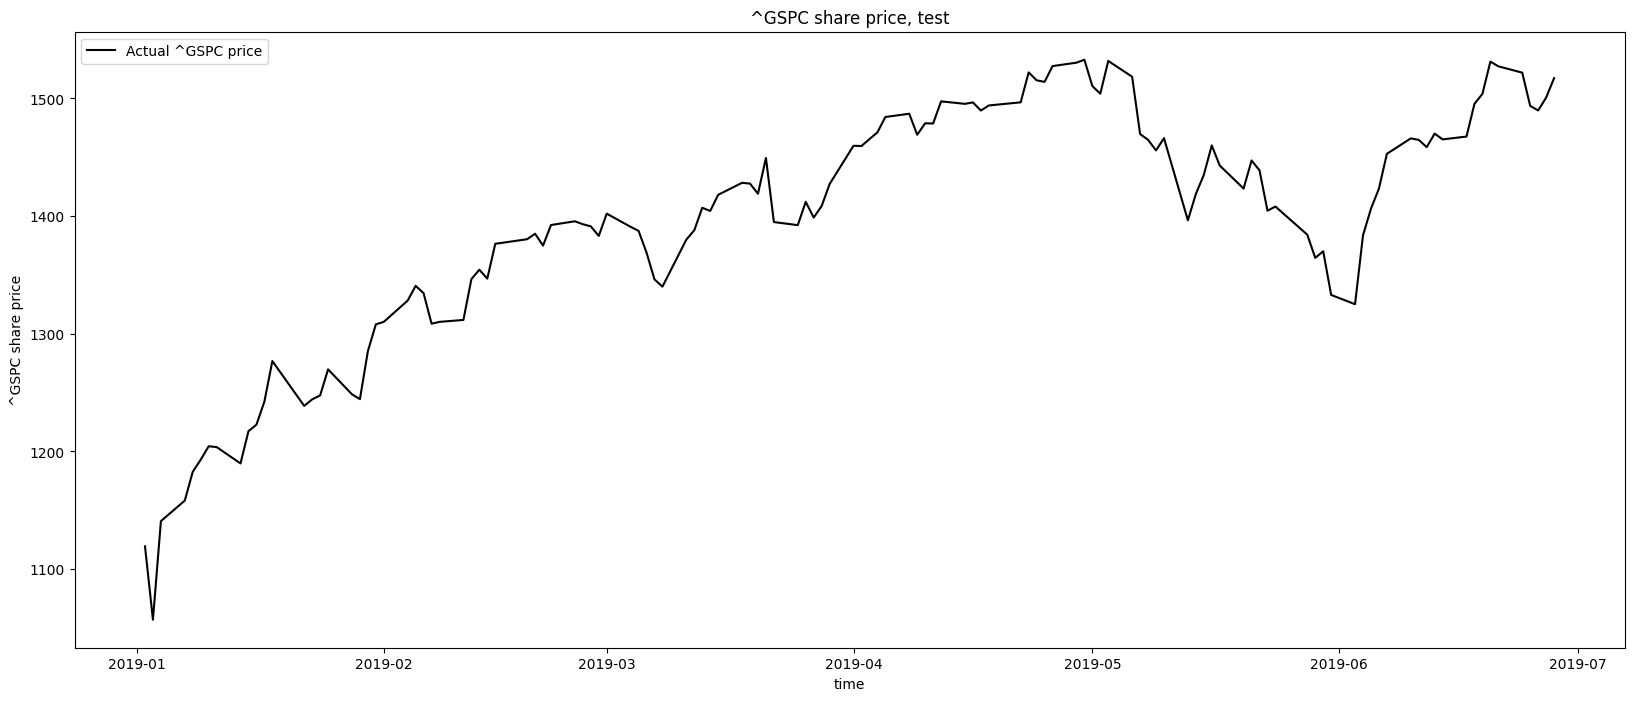

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(test_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, test")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [11]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

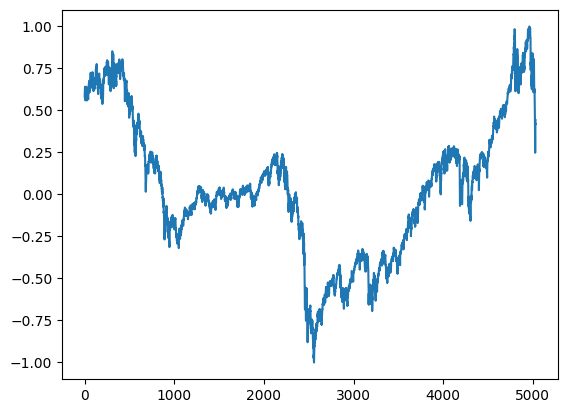

In [12]:
plt.plot(scaled_data)

In [13]:
# how many days do i want to base my predictions on ?
base_day = 250
prediction_day = 30
x_train = []
y_train = []
slide = 10
# 從base_day開始，往前提取base_day天的數據，作為輸入變量x_train，並將當前價格作為輸出變量y_train
for x in range(base_day+prediction_day, len(scaled_data), slide):
    x_train.append(scaled_data[x-base_day-prediction_day:x-prediction_day, 0])
    y_train.append(scaled_data[x-prediction_day:x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [14]:
x_train.shape

(476, 250, 1)

In [15]:
y_train.shape

(476, 30, 1)

# <div id="chap3">3. Build LSTM model

In [16]:
def LSTM_model(prediction_day):
    
    model = Sequential()
    
    model.add(LSTM(units = 256, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    
    model.add(Dense(units=prediction_day))
    
    return model

# <div id="chap4">4. Training

In [17]:
# model = LSTM_model()
# model.summary()
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define callbacks
# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
# earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

# history = model.fit(x_train, y_train, epochs=25, batch_size = 32, callbacks = [checkpointer, earlystopper], validation_split = 0.2)

# # plot loss curves
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()


In [18]:
model = LSTM_model(prediction_day)
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 256)          264192    
                                                                 
 dropout (Dropout)           (None, 250, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 250, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 250, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 30)                1

In [19]:
# # Define callbacks

# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
#                                verbose = 2, 
#                                save_best_only = True)

# model.fit(x_train, 
#           y_train, 
#           epochs=25, 
#           batch_size = 32,
#           callbacks = [checkpointer])

In [20]:
# Define callbacks
# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 90, verbose = 2)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks = [checkpointer, earlystopper], validation_split = 0.2, shuffle=True)


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0740
Epoch 1: val_loss improved from inf to 0.04942, saving model to weights_best.hdf5
12/12 [==============================] - 34s 2s/step - loss: 0.0740 - val_loss: 0.0494
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0357
Epoch 2: val_loss improved from 0.04942 to 0.03161, saving model to weights_best.hdf5
12/12 [==============================] - 26s 2s/step - loss: 0.0357 - val_loss: 0.0316
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0251
Epoch 3: val_loss improved from 0.03161 to 0.02257, saving model to weights_best.hdf5
12/12 [==============================] - 26s 2s/step - loss: 0.0251 - val_loss: 0.0226
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0216
Epoch 4: val_loss improved from 0.02257 to 0.01634, saving model to weights_best.hdf5
12/12 [==============================] - 29s 2s/step - loss: 0.0216 - val_loss: 0.0163
Epoch 5/

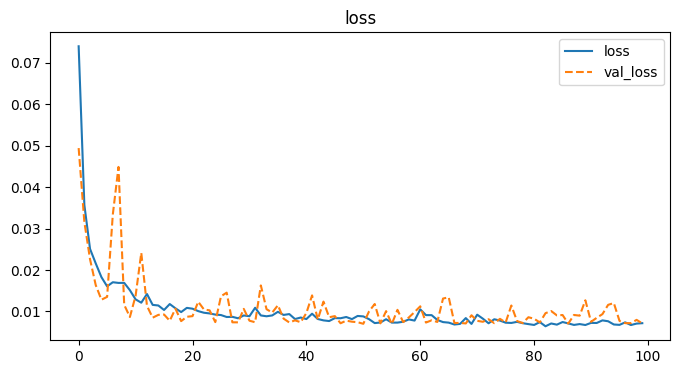

In [21]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()



# <div id="chap5">5. Predictions

In [22]:
# test model accuracy on existing data

actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-base_day:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

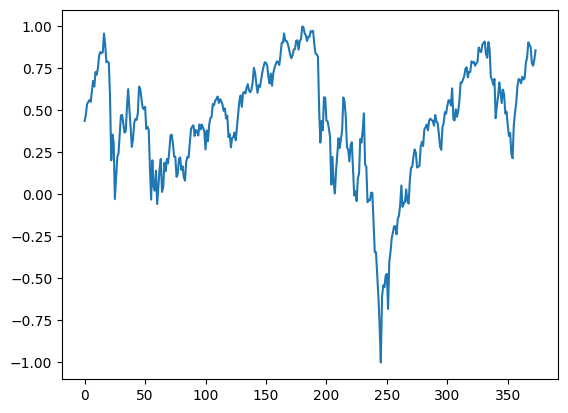

In [23]:
plt.plot(model_inputs)

In [24]:
x_test = []
y_test = []
for x in range(base_day+prediction_day, len(model_inputs), slide):
    x_test.append(model_inputs[x-base_day-prediction_day:x-prediction_day, 0])
    y_test.append(model_inputs[x-prediction_day:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
# predicted_prices = scaler.inverse_transform(predicted_prices)
print(f"predicted_prices: {predicted_prices}")

1/1 [==============================] - 2s 2s/step
predicted_prices: [[-0.6072311  -0.60707027 -0.6134784  -0.59587514 -0.59192014 -0.60326564
  -0.5909992  -0.60779357 -0.5870915  -0.6029173  -0.59807074 -0.5965954
  -0.58836174 -0.58706063 -0.5891622  -0.58115876 -0.5860325  -0.579649
  -0.59513915 -0.59181935 -0.58335596 -0.58670896 -0.5851082  -0.5811767
  -0.5997104  -0.59552467 -0.5852703  -0.573865   -0.5864751  -0.57011163]
 [-0.21810988 -0.21221146 -0.22370195 -0.2101691  -0.21072198 -0.21557903
  -0.21635608 -0.21742953 -0.21167314 -0.2144572  -0.21666242 -0.21171409
  -0.2114222  -0.21664298 -0.21670786 -0.21963242 -0.21371117 -0.21435077
  -0.22483209 -0.21638907 -0.21335107 -0.20728675 -0.22227778 -0.21028444
  -0.2127125  -0.21905881 -0.21205682 -0.21506189 -0.2138782  -0.2098501 ]
 [-0.01640046 -0.01519684 -0.0209759  -0.01875361 -0.01820136 -0.01589671
  -0.01512983 -0.01677617 -0.01869344 -0.01824659 -0.02223102 -0.0164517
  -0.02226558 -0.02344382 -0.02019124 -0.022942

In [25]:
type(predicted_prices)

numpy.ndarray

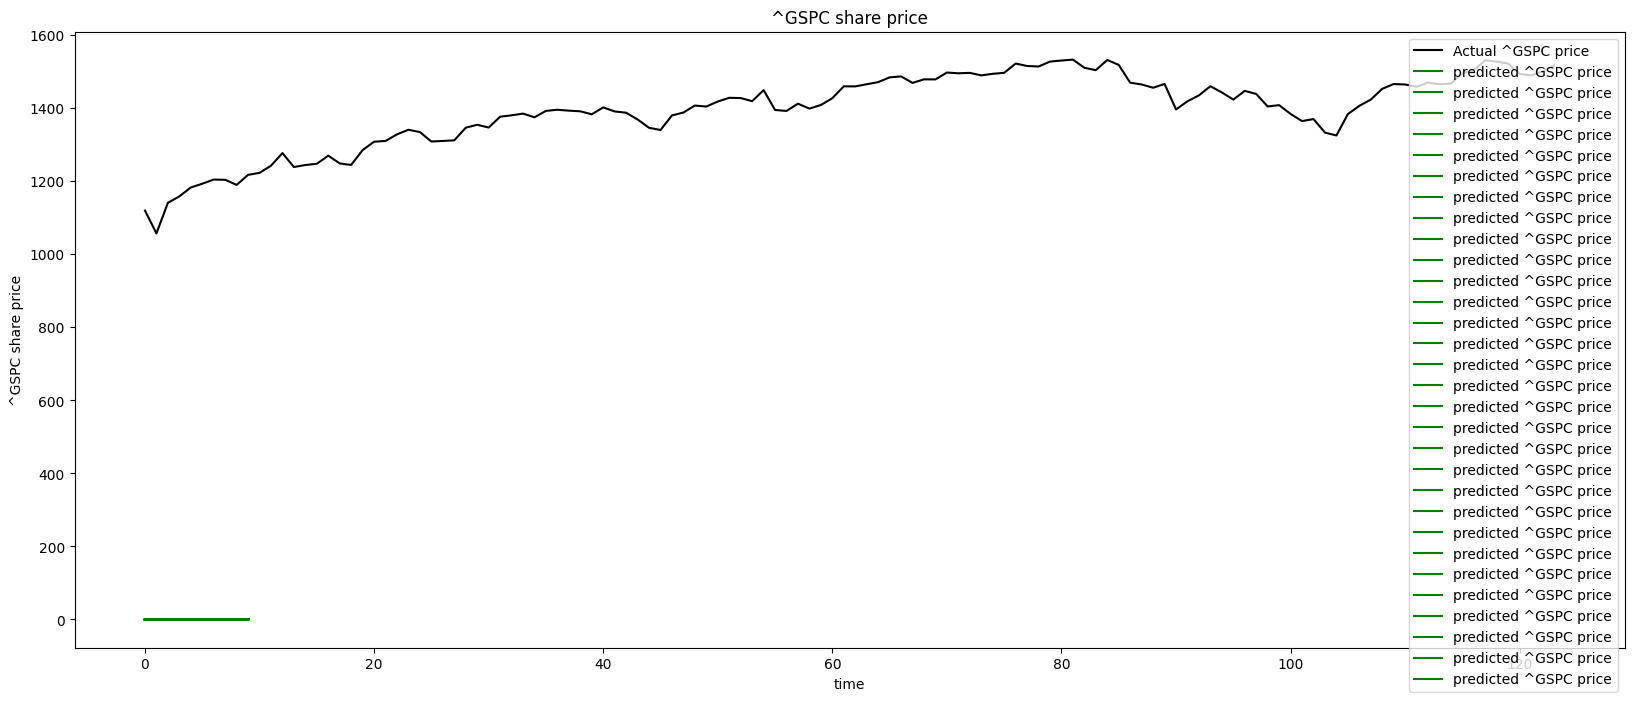

In [26]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color='green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

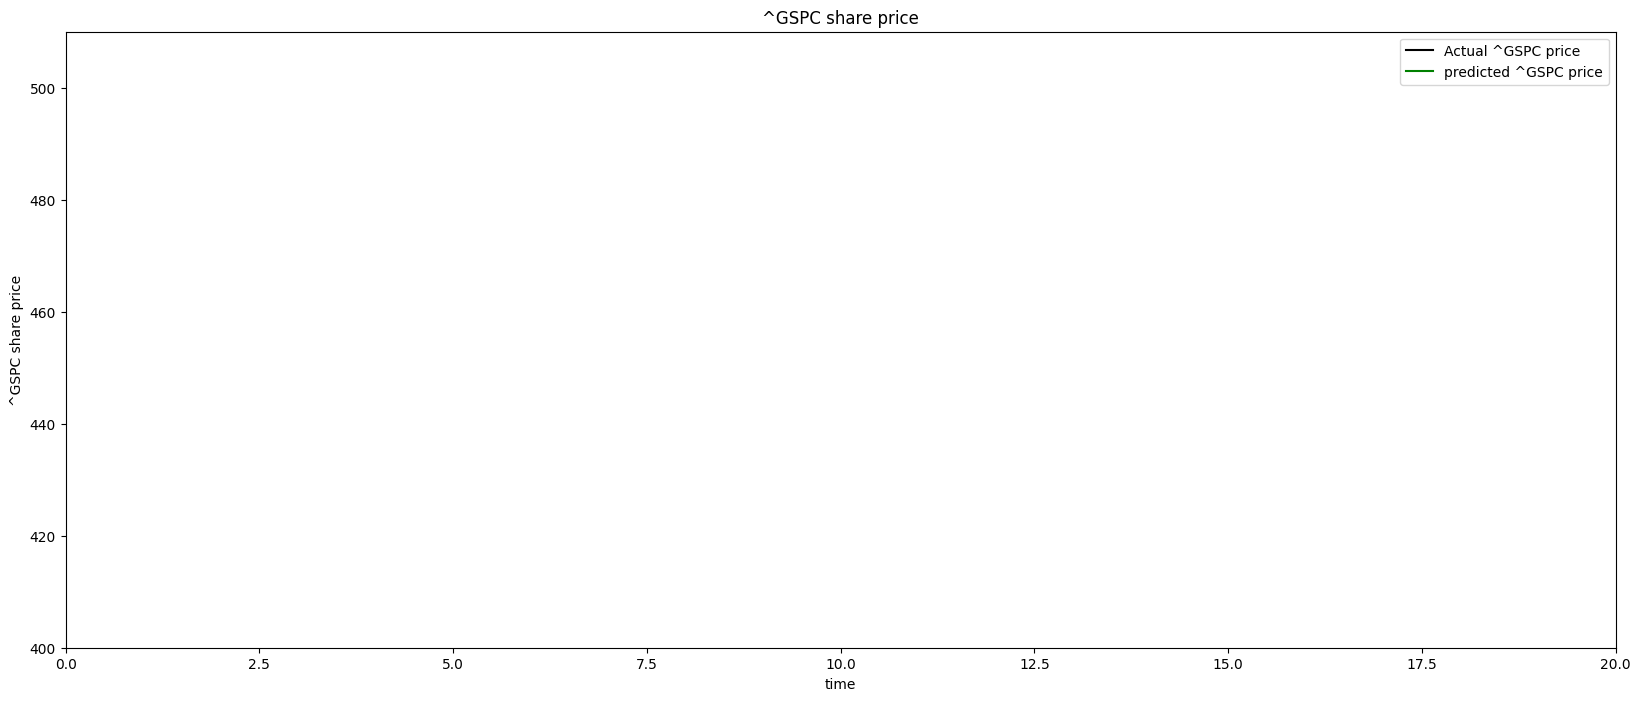

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices[0], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.xlim(0, 20)
plt.ylim(400, 510)
plt.legend()
plt.show()

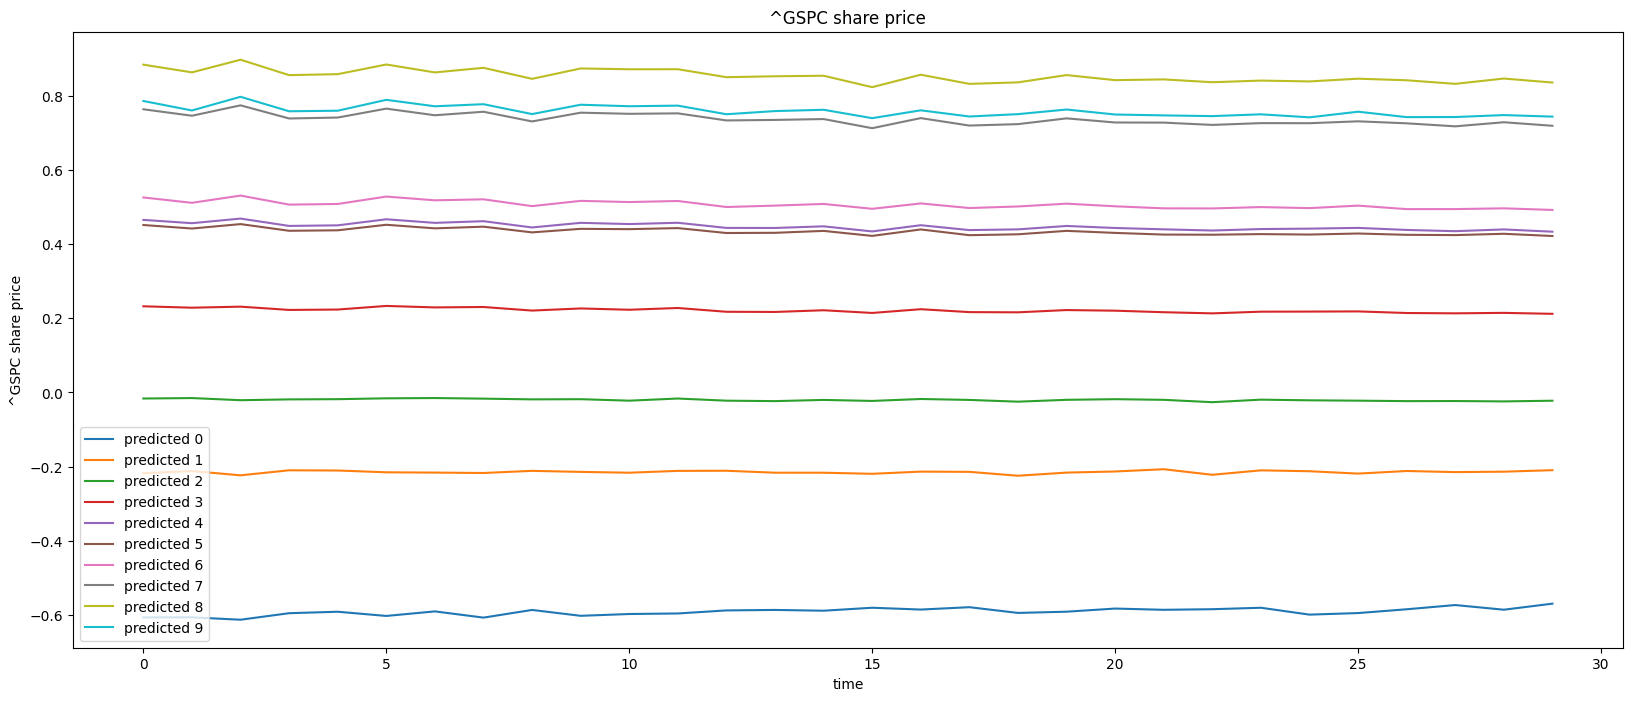

In [28]:
plt.figure(figsize=(20, 8))
for i in range(0, 10):
    plt.plot(predicted_prices[i], label=f"predicted {i}")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
# plt.xlim(0, 9)
# plt.ylim(400, 510)
plt.legend()
plt.show()

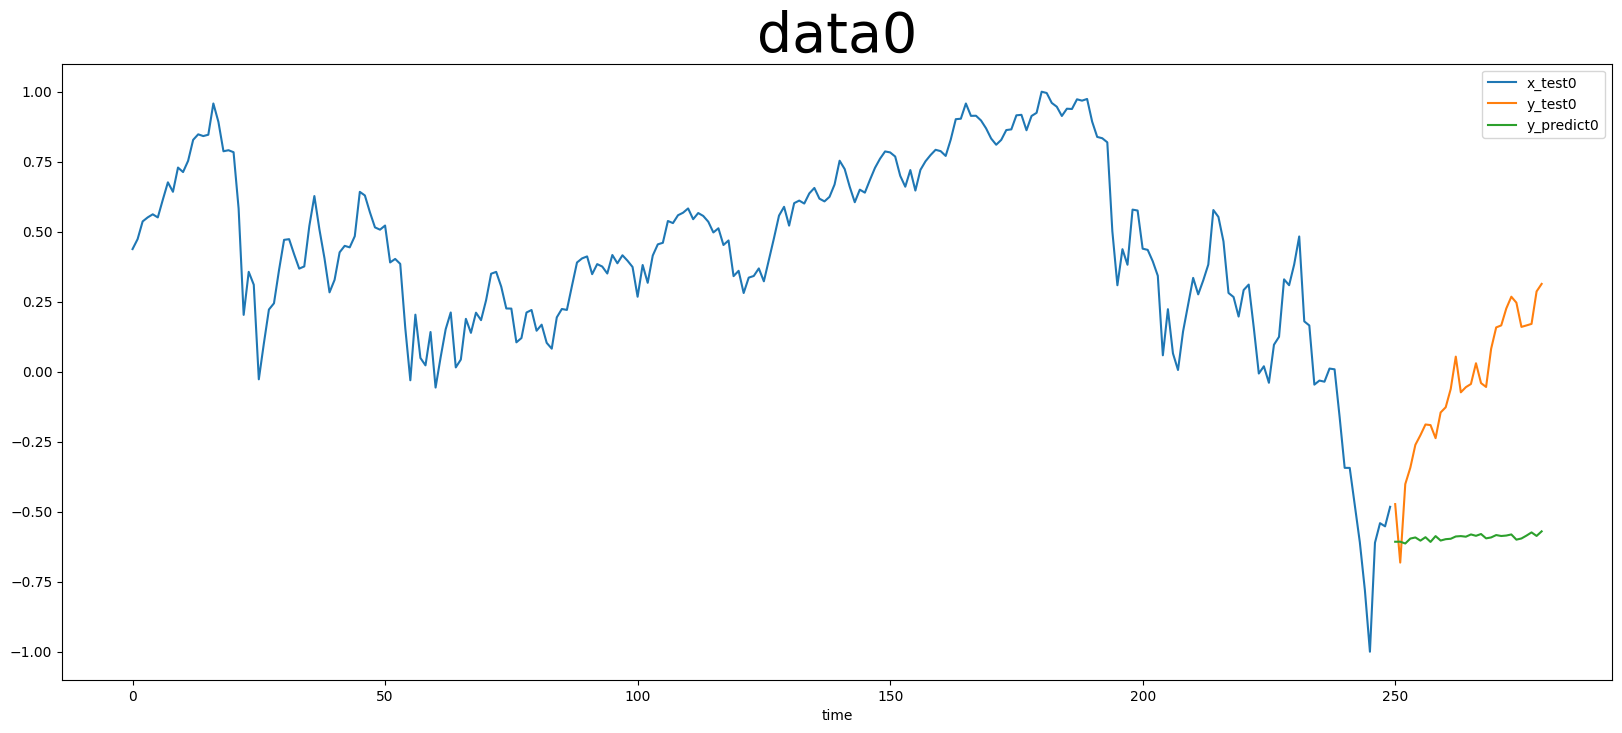

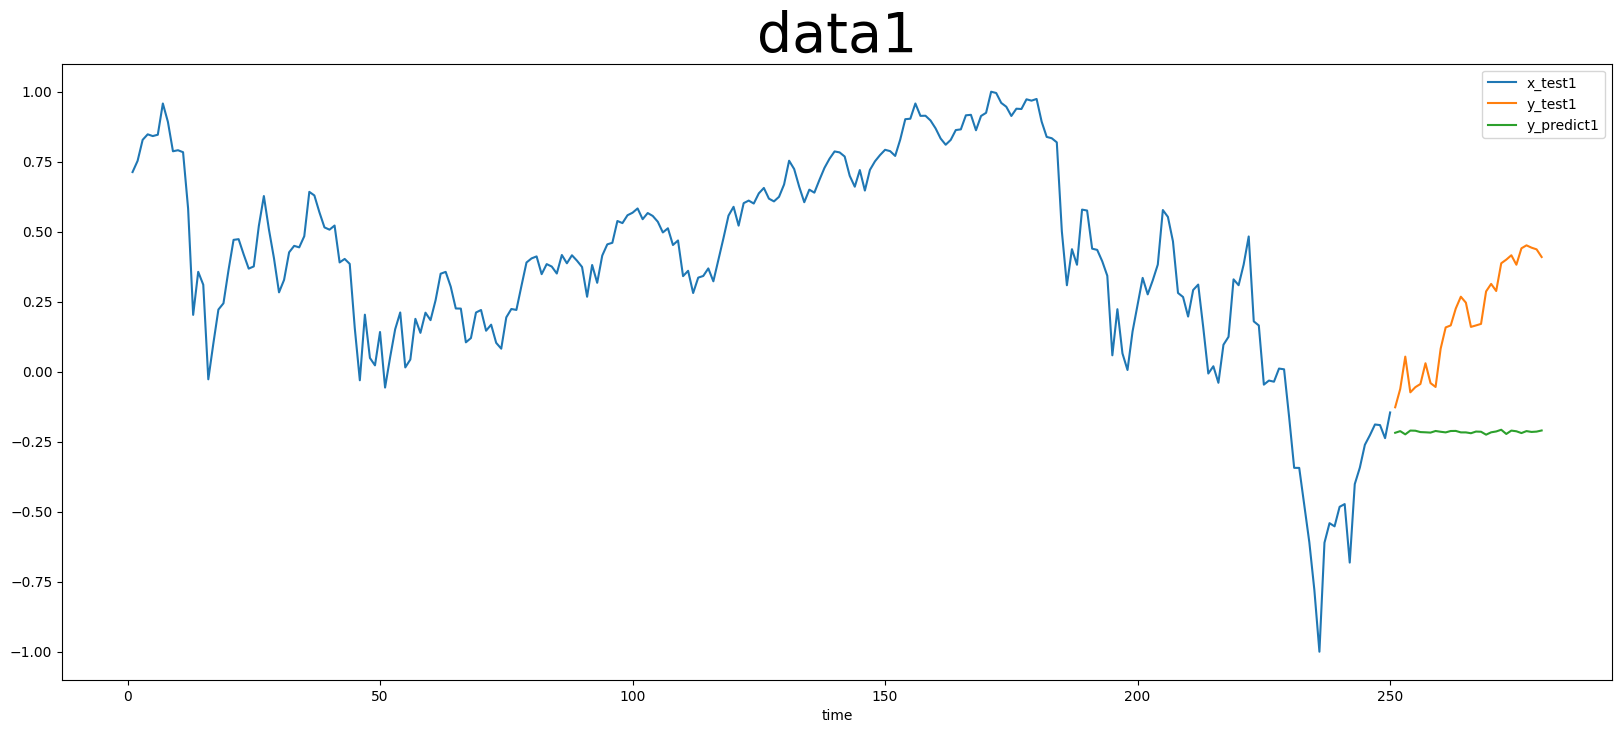

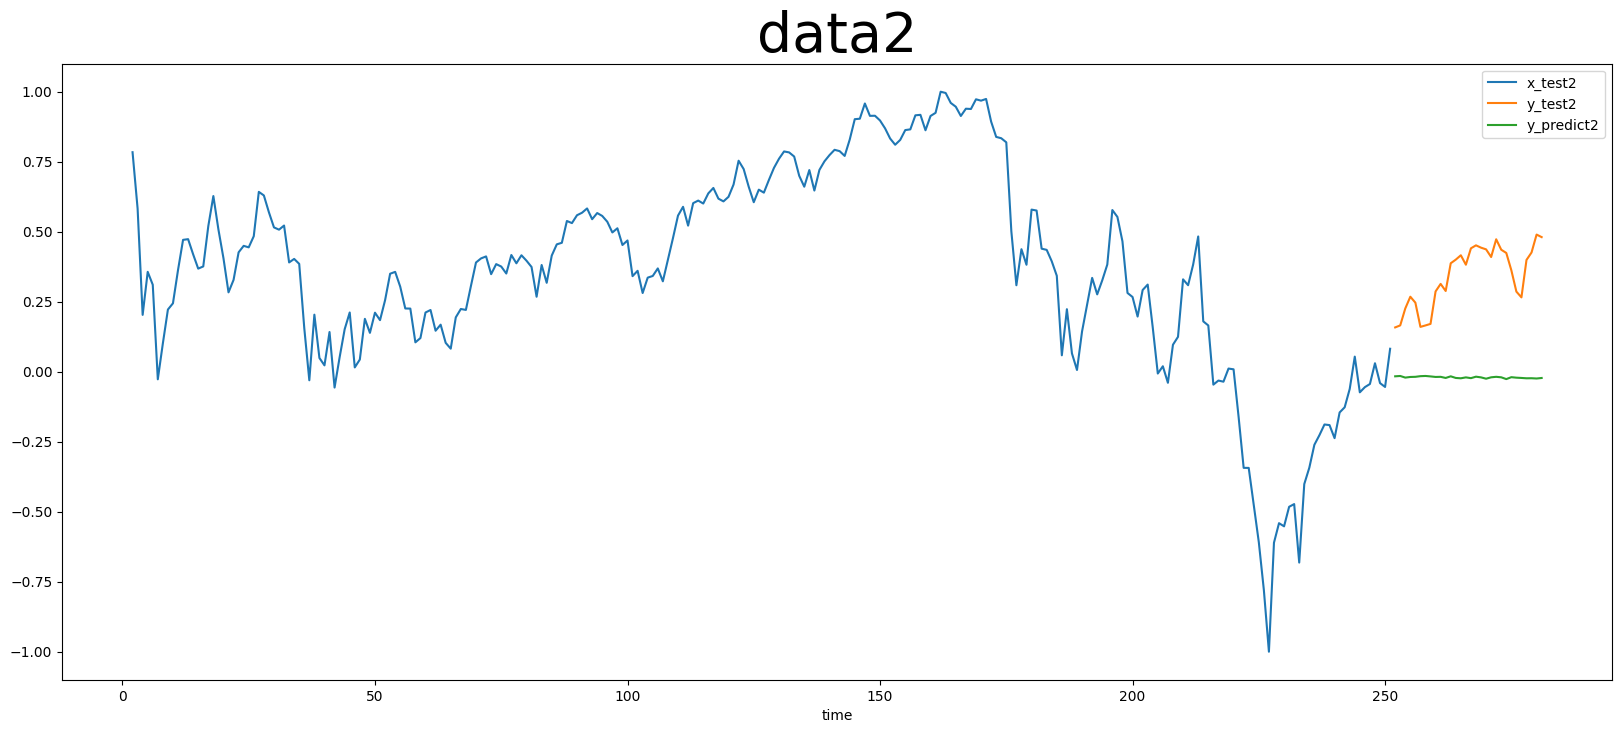

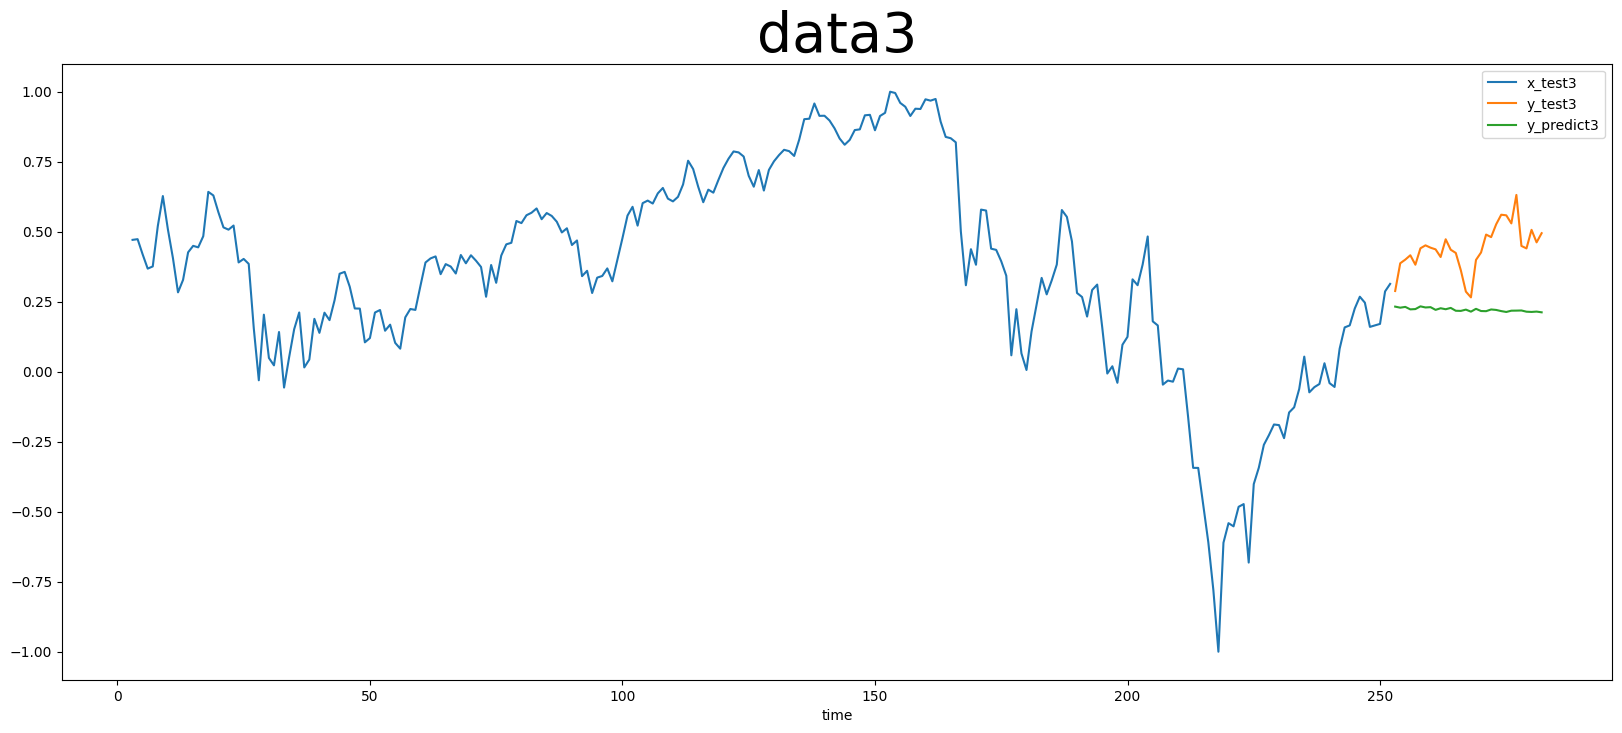

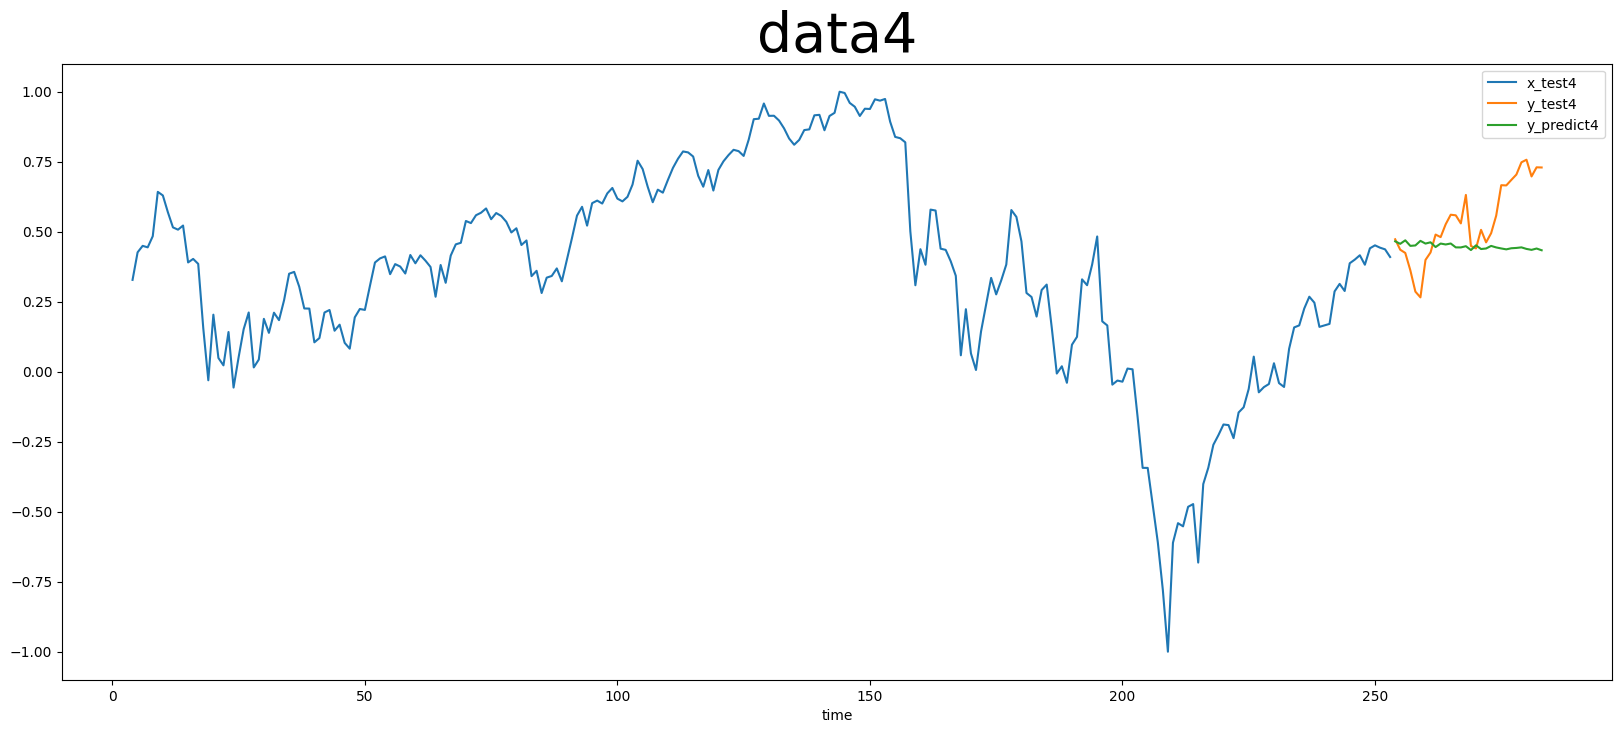

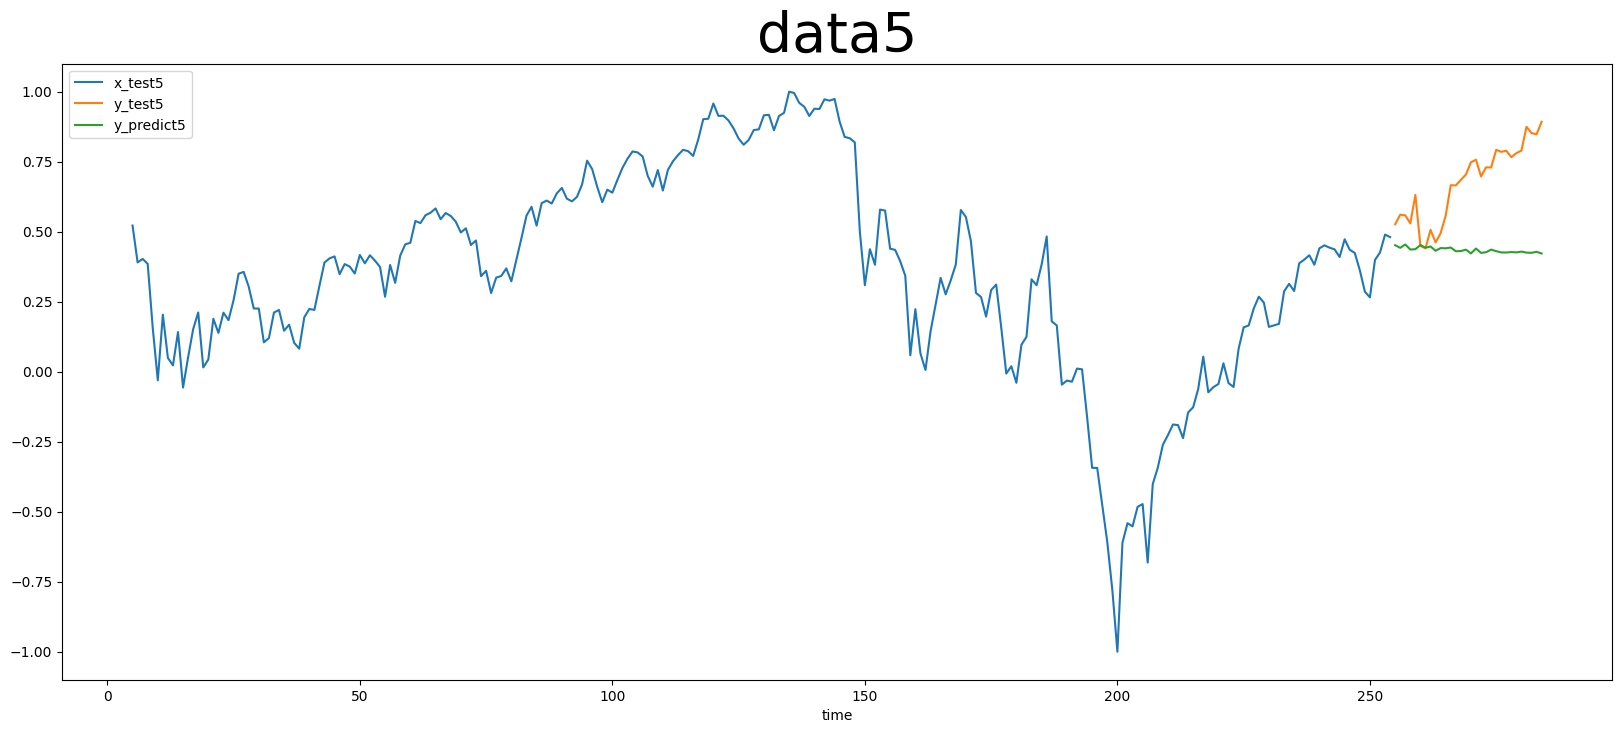

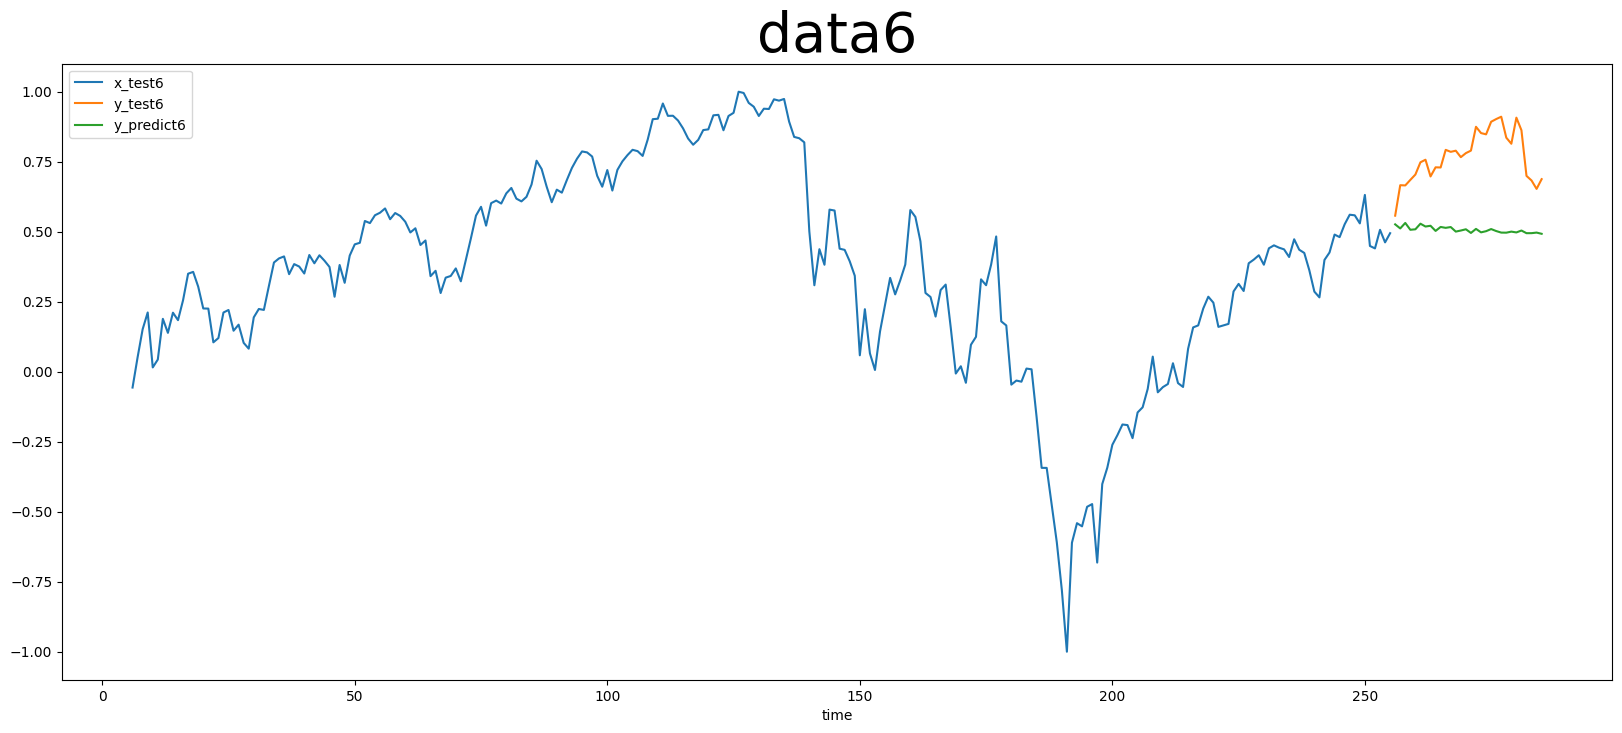

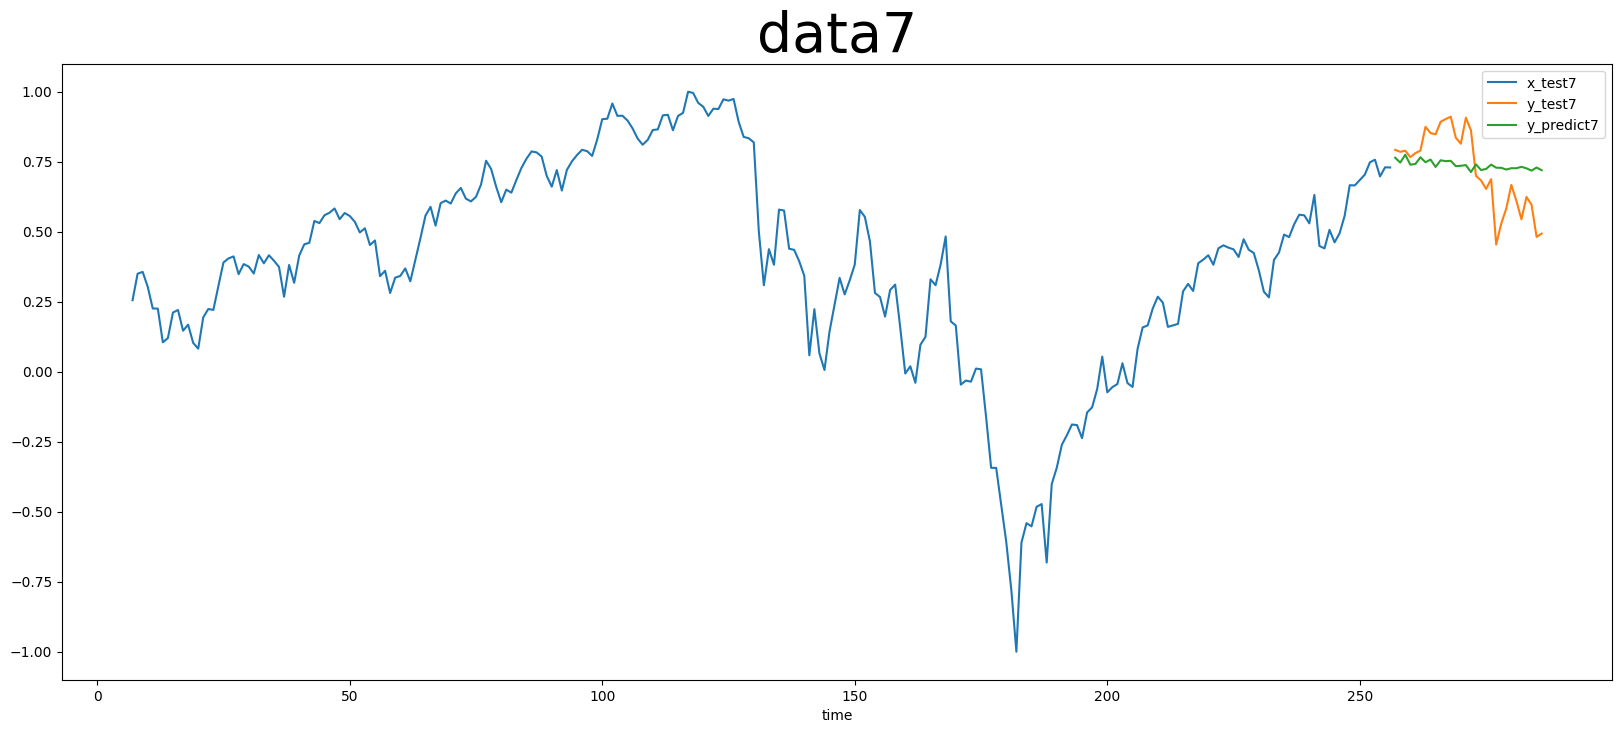

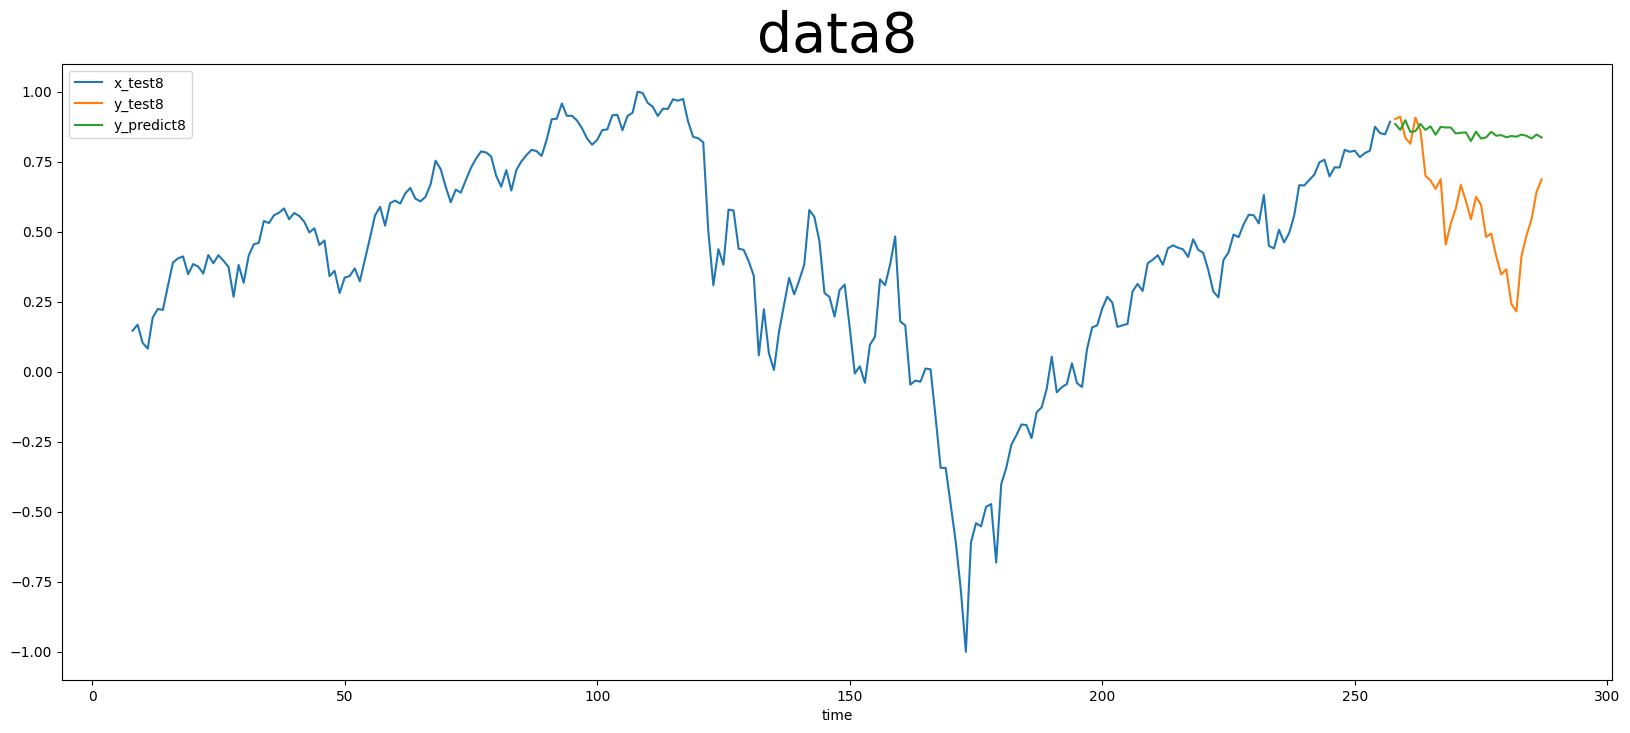

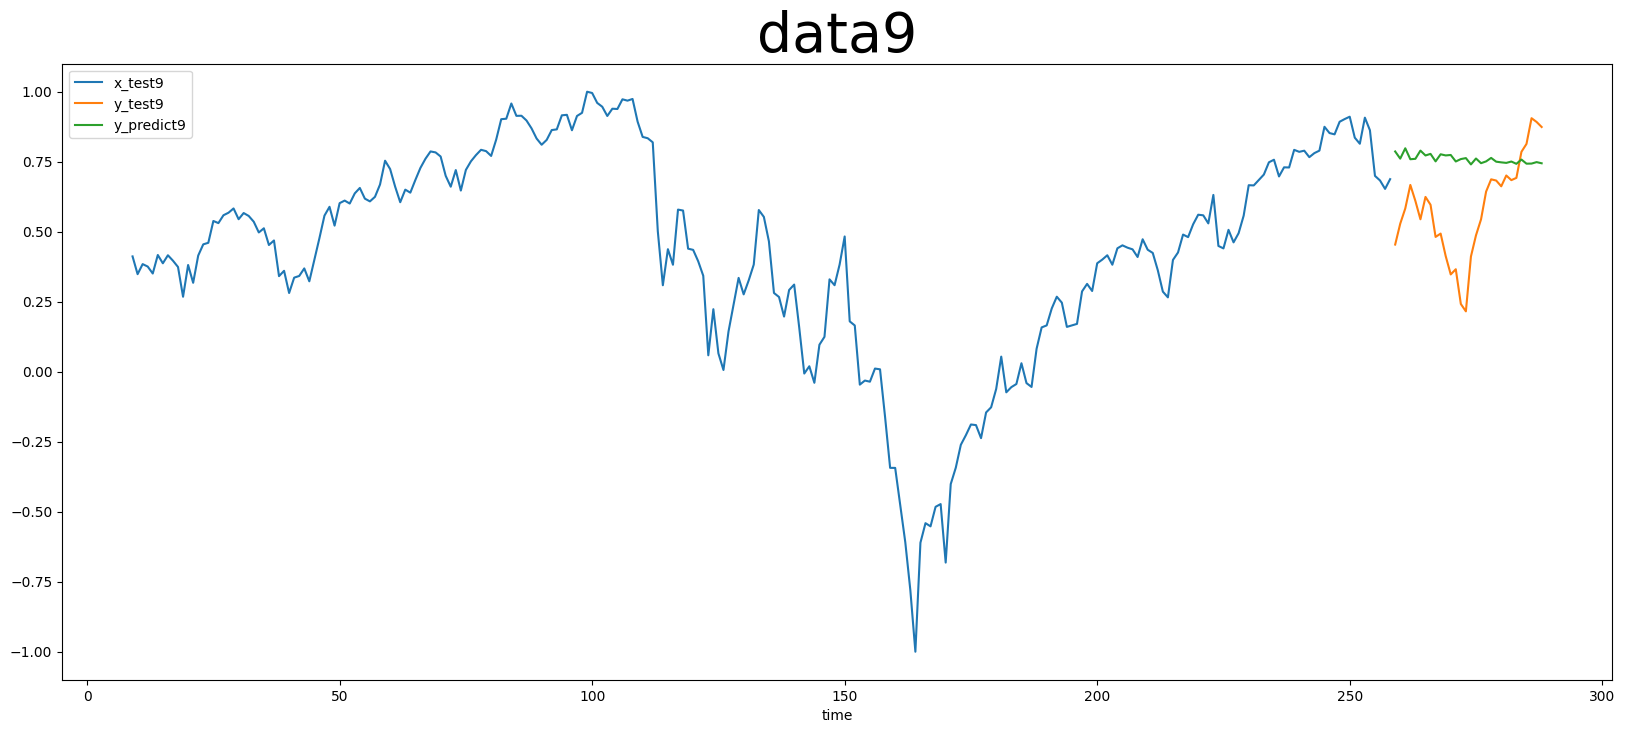

In [29]:
for num in range(0, 10, 1):
    plt.figure(figsize=(20, 8))
    for i in range(num, num+1):
        start = i
        singal = x_test[start]
        plt.plot(range(start,len(singal)+start), singal, label=f"x_test{i}")
    for i in range(num, num+1):
        start = i
        singal = y_test[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_test{i}")
    for i in range(num, num+1):
        start = i
        singal = predicted_prices[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_predict{i}")
    plt.xlabel("time")
    plt.title(f"data{i}", fontsize=40)
    plt.legend()
    plt.show()

In [30]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valley'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valley'


In [31]:
predicted_prices.shape[1]

30

In [32]:
def find_signal_pv_function(signal_souce, pv_range, test_data, slide):
    pd.options.mode.chained_assignment = None
    signal = {}
    for i in range(0, predicted_prices.shape[0]):
        data = pd.Series(signal_souce[i])
        signal[i] = pd.DataFrame()
        signal[i]['Close'] = data
        signal[i].index = test_data.index[range(i*slide, i*slide+predicted_prices.shape[1])]
        signal[i]['peaks'] = pd.Series(dtype='float64')
        signal[i]['valleys'] = pd.Series(dtype='float64')
        signal[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(data)):
            if idx < pv_range:
                if data[idx] == data.iloc[0:pv_range*2+1].max():
                    signal[i]['peaks'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[0:pv_range*2+1].min():
                    signal[i]['valleys'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'valley'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                signal[i]['peaks'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'peak'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                signal[i]['valleys'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'valley'
    return signal


In [33]:
pv_range = 2
test_data['Close'] = actual_prices
find_data_pv_CL_function(test_data, pv_range)
processed_signal = find_signal_pv_function(predicted_prices, pv_range, test_data, slide)

C:\Users\e4903\AppData\Local\Temp\ipykernel_7140\849117802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Close'] = actual_prices


In [34]:
def find_signal_lead_train_function(data, processed_signal):
    for p in processed_signal:
        data = test_data.loc[processed_signal[p].index[0]:processed_signal[p].index[-1]]
        processing_signal = processed_signal[p]
        p_data = pd.DataFrame(
            {'peaks': data['peaks'], 'count': range(len(data))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data['valleys'], 'count': range(len(data))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[p]['lead'] = pd.Series(dtype='float64')
        processed_signal[p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
        processed_signal[p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']

In [35]:
find_signal_lead_train_function(test_data, processed_signal)

In [36]:
test_data

,Open,High,Low,Close,Adj Close,Volume,peaks,valleys,pv
Date,,,,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,1119.470690,2510.030029,3733160000,NaN,NaN,NaN
2019-01-03,2491.919922,2493.139893,2443.959961,1057.054155,2447.889893,3858830000,NaN,1057.054155,valley
2019-01-04,2474.330078,2538.070068,2474.330078,1140.827806,2531.939941,4234140000,NaN,NaN,NaN
2019-01-07,2535.610107,2566.159912,2524.560059,1158.301407,2549.689941,4133120000,NaN,NaN,NaN
2019-01-08,2568.110107,2579.820068,2547.560059,1182.744980,2574.409912,4120060000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-06-24,2951.419922,2954.919922,2944.050049,1521.899373,2945.350098,3136960000,NaN,NaN,NaN
2019-06-25,2945.780029,2946.520020,2916.010010,1493.652760,2917.379883,3579430000,NaN,NaN,NaN
2019-06-26,2926.070068,2932.590088,2912.989990,1489.776508,2913.780029,3511350000,NaN,1489.776508,valley


In [37]:
processed_signal

{0:                Close     peaks   valleys      pv  lead
 Date                                                  
 2019-01-02 -0.607231       NaN       NaN     NaN   NaN
 2019-01-03 -0.607070       NaN       NaN     NaN   NaN
 2019-01-04 -0.613478       NaN -0.613478  valley  -1.0
 2019-01-07 -0.595875       NaN       NaN     NaN   NaN
 2019-01-08 -0.591920 -0.591920       NaN    peak   2.0
 2019-01-09 -0.603266       NaN -0.603266  valley   3.0
 2019-01-10 -0.590999 -0.590999       NaN    peak   0.0
 2019-01-11 -0.607794       NaN -0.607794  valley   1.0
 2019-01-14 -0.587092 -0.587092       NaN    peak  -2.0
 2019-01-15 -0.602917       NaN       NaN     NaN   NaN
 2019-01-16 -0.598071       NaN       NaN     NaN   NaN
 2019-01-17 -0.596595       NaN       NaN     NaN   NaN
 2019-01-18 -0.588362       NaN       NaN     NaN   NaN
 2019-01-22 -0.587061 -0.587061       NaN    peak  -1.0
 2019-01-23 -0.589162       NaN -0.589162  valley  -1.0
 2019-01-24 -0.581159 -0.581159       NaN    

In [38]:
def get_first_lead_function(processed_signal):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        temp = processed_signal[i].loc[list(
            processed_signal[i]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [39]:
first_date, lead, pv = get_first_lead_function(processed_signal)

In [40]:
def built_result_table_function(processed_signal, lead, pv):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv'])
    for i in processed_signal:
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
        result_table.loc[i, 's_date'] = processed_signal[i].index[0]
    return result_table


In [41]:
result_table = built_result_table_function(processed_signal, lead, pv)
print(result_table)

                s_date t_date lead ans_date      pv
0  2019-01-02 00:00:00    NaN -1.0      NaN  valley
1  2019-01-16 00:00:00    NaN  1.0      NaN  valley
2  2019-01-31 00:00:00    NaN  2.0      NaN    peak
3  2019-02-14 00:00:00    NaN  3.0      NaN    peak
4  2019-03-01 00:00:00    NaN -2.0      NaN    peak
5  2019-03-15 00:00:00    NaN -1.0      NaN    peak
6  2019-03-29 00:00:00    NaN -1.0      NaN    peak
7  2019-04-12 00:00:00    NaN -2.0      NaN    peak
8  2019-04-29 00:00:00    NaN -1.0      NaN    peak
9  2019-05-13 00:00:00    NaN  1.0      NaN    peak


In [42]:
def result_table_process_function(result_table, data, first_date):
    for i in result_table.index:
        t_date = first_date[i]
        result_table.loc[i, 't_date'] = t_date
        ans = data.iloc[int(data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [43]:
result_table_process_function(result_table, test_data, first_date)

In [44]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [45]:
final_error = compute_final_error_function(result_table)

In [46]:
def evaluate_model(processed_signal, test_data, first_date, lead, pv):
    result_table = built_result_table_function(processed_signal, lead, pv)
    result_table_process_function(result_table, test_data, first_date)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error

In [47]:
result_table, final_error = evaluate_model(processed_signal, test_data, first_date, lead, pv)

In [48]:
print(result_table)

                s_date               t_date lead             ans_date      pv
0  2019-01-02 00:00:00  2019-01-04 00:00:00 -1.0  2019-01-03 00:00:00  valley
1  2019-01-16 00:00:00  2019-01-18 00:00:00  1.0  2019-01-22 00:00:00  valley
2  2019-01-31 00:00:00  2019-02-01 00:00:00  2.0  2019-02-05 00:00:00    peak
3  2019-02-14 00:00:00  2019-02-14 00:00:00  3.0  2019-02-20 00:00:00    peak
4  2019-03-01 00:00:00  2019-03-05 00:00:00 -2.0  2019-03-01 00:00:00    peak
5  2019-03-15 00:00:00  2019-03-19 00:00:00 -1.0  2019-03-18 00:00:00    peak
6  2019-03-29 00:00:00  2019-04-02 00:00:00 -1.0  2019-04-01 00:00:00    peak
7  2019-04-12 00:00:00  2019-04-16 00:00:00 -2.0  2019-04-12 00:00:00    peak
8  2019-04-29 00:00:00  2019-05-01 00:00:00 -1.0  2019-04-30 00:00:00    peak
9  2019-05-13 00:00:00  2019-05-15 00:00:00  1.0  2019-05-16 00:00:00    peak


In [49]:
print(f'final_error = {final_error}')

final_error = 1.5


In [50]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data= test_data.drop(test_data[test_data.index > date_list[-1]].index)
    axes[0].plot(test_data.index, test_data['Close'], 'gray', label='data', linewidth=3)
    axes[0].plot(test_data.index, test_data['peaks'],
                '^', c='royalblue', label='peaks')
    axes[0].plot(test_data.index, test_data['valleys'], 'v',
                c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

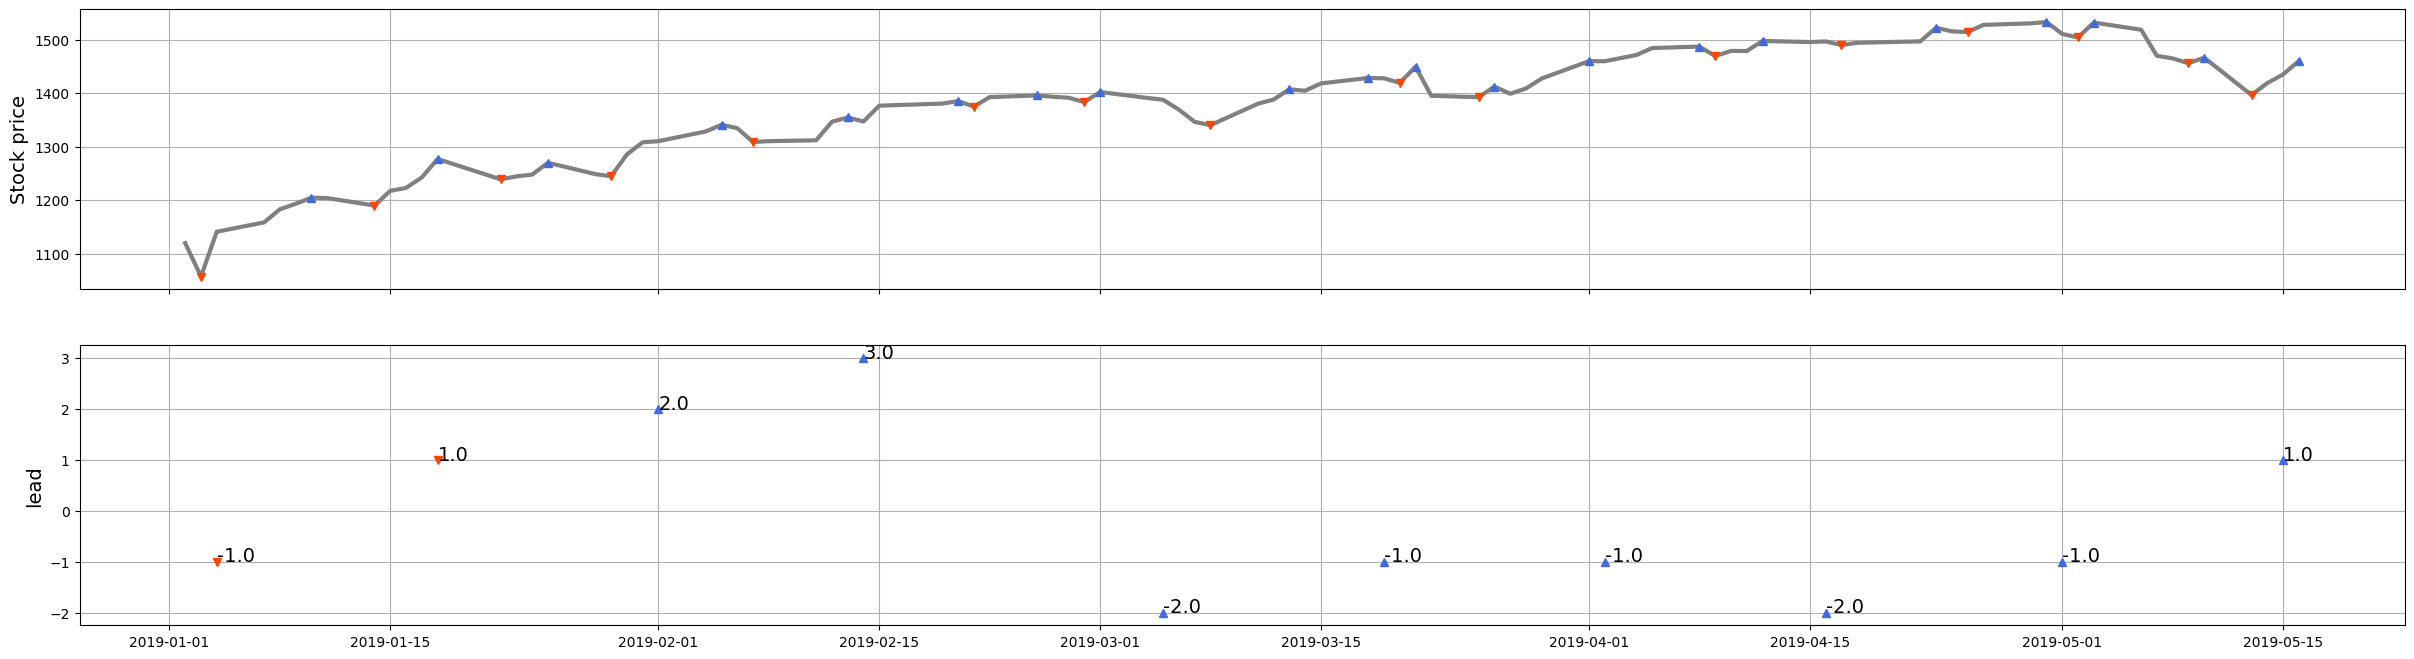

In [51]:
draw_plot_result_table(test_data, data, result_table, pv_range)